In [1]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
import sympy
from ipywidgets import interact
from numba import jit
import time
from sklearn import linear_model
import scipy.sparse

---

# Item II

Let $H_n$ be the $n\times n$ Hilbert matrix whose $ij$-th entry is defined as $1/(i+j-1)$, also, let $\mathbf{1}_n$ be the vector of ones of dimension $n$. *Discuss the following questions.*
1. Find, as accurate as possible, the approximate solution $\hat{\mathbf{x}}$ of the linear system $A\mathbf{x}=\mathbf{b}$, where $A=H_n$ and $\mathbf{b}= H_n\mathbf{1}_n$ for $n=3\dots 20$. Notice that we know a priori that the exact solution is just $\mathbf{x} = \mathbf{1}_n$, but (un)fortunately the computer can only give you $\tilde{\mathbf{x}}$.
2. What is the relation between $\mathbf{x}$ and $\tilde{\mathbf{x}}$?
3. What can we do now?

---

In [2]:
def hilbert(n):
    v = np.arange(1,n+1,dtype='float')
    iis = v.reshape((1,n))
    jjs = v.reshape((n,1))
    return (iis+jjs-1)**-1

In [3]:
NS = np.arange(3,20+1)
errors = []

for n in NS:
    H = hilbert(n)
    real_x = np.ones(n)
    b = np.dot(H,real_x)
    x = np.linalg.solve(H,b)# We use np.linalg.solve
    err = np.mean(np.abs((x-real_x)/real_x))
    errors.append(err)
    
errors = np.array(errors)

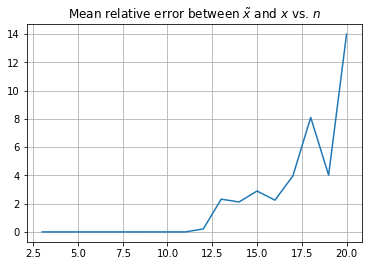

In [4]:
# Plot errors
plt.plot(NS,errors)
plt.grid()
plt.title("Mean relative error between $\\tilde{x}$ and $x$ vs. $n$")
plt.plot()
pass

We see that as $n$ grows, the relative error between $\tilde{\mathbf{x}}$ and $\mathbf{x}$ grows fast.

This is because $\text{cond}(H_n) = O\left( \left(1+\sqrt{2}\right)^{4n}/\sqrt{n}\right)$, so, given small perturbations on the operations required to solve the problem, the error on the solution grows considerably with $n$.

---

To solve the problem we can try to minimize instead of finding the exact solution

In [5]:
lstsq_errors = []

for n in NS:
    H = hilbert(n)
    real_x = np.ones(n)
    b = np.dot(H,real_x)
    x,_,_,_ = np.linalg.lstsq(H,b,rcond=None)
    err = np.mean(np.abs((x-real_x)/real_x))
    lstsq_errors.append(err)

lstsq_errors = np.array(lstsq_errors)

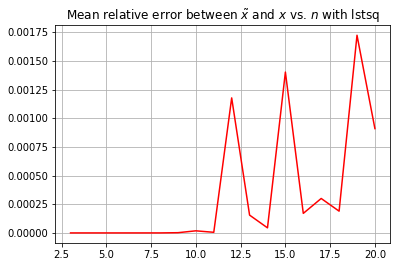

In [6]:
# Plot errors
plt.plot(NS,lstsq_errors,c="#ff0000")
plt.grid()
plt.title("Mean relative error between $\\tilde{x}$ and $x$ vs. $n$ with lstsq")
plt.plot()
pass

We can see that approaching the problem like a minimization gives far better results, because it can perform more iterations to correct numerical errors.


# Item III

*Solving a very (un)known problem*

1. Implement a function that finds the two roots of the quadratic equation $a x^2 + b x + c = 0$ given $a$,$b$, and $c$, i.e. implement $x_{\pm} = \frac{-b \pm \sqrt{b^2-4ac}}{2a}$.
2. What are the roots of $2x^2+10^9+1 = 0$? How many digits of significance can you get for the two roots? Is there any problem?
3. Design a code that finds the correct roots for $x^2+Bx+C=0$, given $B \gg C$ to at least 2 digits of significance.
4. Solve the previous equation using this new code and find the new roots. *I hope it works!*
5. From the well-known solution $x_{\pm}$ of the quadratic equation design an algorithm that approximates the two roots of $x^2+Bx+C = 0$, given $B \gg C$. Hint: *A Taylor expansion may work*.
---

## Part 1

In [7]:
def solve_quadratic(a,b,c):
    assert(a!=0)
    disc = (b**2-4*a*c+0j)**0.5
    x1 = (-b-disc)/(2*a)
    x2 = (-b+disc)/(2*a)
    return (x1,x2)

## Part 2

The analytical solution is:
$$
x_{\pm} = \frac{-10^{9}\pm\sqrt{10^{18}-8}}{4}
$$

In [8]:
# if we use the solver
x1,x2 = solve_quadratic(2,1e9,1)
print("x-:",x1)
print("x+:",x2)

x-: (-500000000+0j)
x+: 0j


The approximation given for $x_{-}$ is good since the relative error is very little (the approximation $\sqrt{10^{18}-8} \approx 10^{9}$ that the computer does because of the *absorption* of the much smaller $-8$ doesn't affect the relative error too much).
<!-- we have as many digits of significance as the double's allow, since -->

For $x_{+}$ however, the error is equal to the value of the root, since  

## Part 3

We make the following change to the equation:
\begin{align}
x_{\pm} = \frac{-b \pm \sqrt{b^2-4ac}}{2a} &= \frac{-b \pm \sqrt{b^2-4ac}}{2a} \cdot \frac{-b \mp \sqrt{b^2-4ac}}{-b \mp \sqrt{b^2-4ac}}
\\ &= \frac{4ac}{2a \left(-b \mp \sqrt{b^2-4ac}\right)}
\\ &= \frac{-2c}{\left(b \pm \sqrt{b^2-4ac}\right)}
\end{align}
we can use it for $x_{+}$ if $b>0$ or $x_{-}$ otherwise.

In [9]:
def solve_quadratic_2(a,b,c):
    assert(a!=0)
    disc = (b**2-4*a*c+0j)**0.5
    if b>0:
        x1 = (-b-disc)/(2*a)
        x2 = -2*c/(b+disc)
    else:
        x1 = -2*c/(b-disc)
        x2 = (-b+disc)/(2*a)
    return (x1,x2)

## Part 4

We solve using the new method and see that it works.

In [10]:
x1,x2 = solve_quadratic_2(2,1e9,1)
print("x-:",x1)
print("x+:",x2)

x-: (-500000000+0j)
x+: (-1e-09+0j)


## Part 5

If $C$ is small, we can approximate the solution:
$$
x = x_0 + C x_1 + C^2 x_2 + ...
$$

Then
$$
\begin{align}
x^2 + B x + C &= 0
\\ (x_0^2 + C (2x_0x_1) + C^2 (x_1^2 + 2x_0x_2) + \dots) + (Bx_0 + C B x_1 + C^2 B x_2 + \dots) + C &= 0
\end{align}
$$
And we have the following equations:
\begin{align}
O(C^0) :  &\qquad x_0^2 + B x_0 = 0 
\\ O(C^1) :  &\qquad 2x_0x_1 + B x_1 +1 = 0 
\\ O(C^2) :  &\qquad x_1^2 + 2 x_0x_2 + B x_2 = 0 
\end{align}
which have the following solutions:
$$
(x_0,x_1,x_2)_1 = \left(0,\frac{-1}{B},\frac{-1}{B^3}\right)
$$
$$
(x_0,x_1,x_2)_2 = \left(-B,\frac{1}{B},\frac{1}{B^3}\right)
$$
which result in the following approximations for $x$:
$$
\begin{align}
x_{1} &= 0 + C \frac{-1}{B} + C^2 \frac{-1}{B^3} + \cdots
\\ x_{2} &= -B + C \frac{1}{B} + C^2 \frac{1}{B^3} + \cdots
\end{align}
$$

In [11]:
def solve_quadratic_3(a,b,c):
    # In case a!=1 we just have to scale the equation:
    b /= a
    c /= a
    # Approximations:
    x1 = 0+c*(-1/b)+c**2*(-1/b**3)
    x2 = -b+c*(1/b)+c**2*(1/b**3)
    return (x1,x2)

In [12]:
x1,x2 = solve_quadratic_3(2,1e9,1)
print("x1:",x1)
print("x2:",x2)

x1: -1e-09
x2: -500000000.0


---

# Item IV

A *fix-point-iteration review*. See Numerical Analysis, 2nd edition by Timothy Sauer.

* Definition 1: The real number $r$ is a fix-point of the function $g(x)$ if $g(r)=r$.
* Algorithm 1: Fixed-Point-Iteration: Let $x_0$ be the initial guess. Compute $x_{i+1} = g(x_i)$, for $i=0,1,2,3,\dots$. Notice that this fixed-point-iteration may or may not converge to $r$.
* Definition 2: Let $e=|r-x_i|$ be the error at iteration $i$. If $0 < \lim_{i \rightarrow \infty} \frac{e_{i+1}}{e_i} = S < 1$, the fixed-point-iteration $x_{i+1} = g(x_i)$ is said to obey linear convergence with rate $S$.
* Theorem 1: Assume that $g(x)$ is continuously differentiable and that $S=|g'(x)|<1$. Then the fixed-point-iteration $x_{i+1}=g(x_i)$ converges at least linearly with rate $S$ to the fixed point $r$ for the initial guesses sufficiently close to $r$.

---

* **Question 1**: Prove that a continuously differentiable function $g(x)$ satisfying $|g'(x)|<1$ on a closed interval cannot have two fixed points on that interval.

__Dem__:

By contradiction, let's asume that $g(x)$ has two fixed points, $x_1$ and $x_2$, with $x_1 \neq x_2$ on the interval $[a,b]$, and that $|g'(x)|< 1 \, \forall (x \in [a,b])$, then we have that:
$$
g(x_1) = x_1 \qquad g(x_2) = x_2 \,.
$$

Given, this two points, by the [mean value theorem](https://en.wikipedia.org/wiki/Mean_value_theorem), there should exist a point $c \in [x_1,x_2]$ so that:
$$
g'(c) = \frac{g(x_1)-g(x_2)}{x_1-x_2} = \frac{x_1-x_2}{x_1-x_2} = 1
$$
as $c \in [x_1,x_2] \Rightarrow c \in [a,b]$, we have a contradiction, since we said that $|g'(x)|<1 \, \forall (x \in [a,b])$.

---

* **Question 2**: Given that $f(x)$ has a root near $x_0$. Derive three different fix-point-iterations that may converge to $f(r)=0$ and state the restrictions of $f(x)$ needed, if any. Assume that $f(x)$ has as many derivatives as you may need.

(1) We have the trivial options (as $x \rightarrow r$):
\begin{align}
0 &= f(x)
\\ x &= \underbrace{\pm f(x) + x}_{g(x)} 
\end{align}
it requires that $|g'(r)| = |\pm f'(r) + 1| \leq 1$, we may choose the sign of $\pm$.

(2) We expand the Taylor series arround $x_0$:
\begin{align}
f(x) &= f(x_0) + f'(x_0)(x-x_0) + \dots
\\  0 &= f(x_0) + f'(x_0)(x-x_0)  \qquad \qquad \text{as $x\rightarrow r$}
\\ f'(x_0)x &= -f(x_0) + f'(x_0) x_0 
\\ x &= -\frac{f(x_0)}{f'(x_0)} + x_0
\\ x &= \underbrace{x_0 - \frac{f(x_0)}{f'(x_0)}}_{g(x_0)} 
\end{align}
Which corresponds to the Newton's method. It doens't have restrictions.

(2) We expand the Taylor series arround $x_0$:
\begin{align}
f(x) &= f(x_0) + f'(x_0)(x-x_0) + \frac{1}{2}f''(x_0)(x-x_0)^2
\\ 0 &= f(x_0) + f'(x_0)(x-x_0) + \frac{1}{2}f''(x_0)(x-x_0)^2 &\text{as $x\rightarrow r$}
\\ 0 &= f'(x_0) + f''(x_0)x - f''(x_0)x_0 &\text{after $\frac{d(\cdot)}{dx}$}
\\ f''(x_0)x &= f''(x_0)x_0 - f'(x_0)
\\ x &= \underbrace{x_0 - \frac{f'(x_0)}{f''(x_0)}}_{g(x_0)}
\end{align}
Which is the [Newton's method in optimization](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization).

It requires $f''(r)$ to exist, and if we make $|g'(r)| <1$ that results in:
$$
|f'(r) f'''(r)| < |f''(r)|
$$

---

* **Question 3**: Derive a unsuccessful and a successful fix-point-iteration for finding the root of $x^3+x=1$ near $x_0=1$.

Our unsuccessful fix-point-iteration would be:
\begin{align}
x^3+x &= 1
\\ x &= 1-x^3
\\ \text{we make } g(x) &= 1-x^3
\end{align}
it won't converge as $g'(x) = -3x^2$ and $g'(1) = -3$.

Our successful one:
\begin{align}
x^3+x &= 1
\\ x(x^2+1) &= 1
\\ x^2+1 &= \frac{1}{x}
\\ x^2 &= \frac{1}{x}-1
\\ x &= \sqrt{\frac{1}{x}-1}
\\ \text{we make } g(x) &= \sqrt{\frac{1}{x}-1}
\end{align}
it will converge as $g'(x) = -\frac{1}{2} \left( x^{-1}-1 \right)^{-\frac{1}{2}}x^{-2}$ and $g'(1) = 0$.

---

* Algorithm 2: Newton's method: Let $x_0$ be the initial guess. Compute $x_{i+1} = \hat{g}(x_i)$, for $i=0,1,2,3,\dots$, where $\hat{g}=x-(f'(x))^{-1}f(x)$ and $(f'(x))^{-1}$ is the inverse of $f'(x)$, i.e. $(f'(x))^{-1} = 1/f'(x)$.
* Definition 3: Let $e = |r-x_i|$ be the error at iteration $i$. If $\lim_{i \rightarrow \infty} \frac{e_{i+1}}{e_i^2} = M < \infty$, the method is said to be quadratically convergent.

---

* **Question 4**: Prove that Newton's method is quadratically convergent as long as $f'(r) \neq 0$.

**Dem**:

We have that $g(x) = x - \frac{f(x)}{f'(x)}$. Expanding a Taylor's series around $r$:
\begin{align}
g(x_i) &= g(r) + g'(r)(x_i-r) + \frac{1}{2}g''(r)(x_i-r)^2 + \dots 
\\ x_{i+1} &= r + g'(r)(x_i-r) + \frac{1}{2}g''(r)(x_i-r)^2 + \dots
\end{align}

We can see that:
\begin{align}
g'(x) &= 1 - \frac{f'(x)f'(x)-f(x)f''(x)}{(f'(x))^2}
\\ g'(r) &= 1 - \frac{f'(r)f'(r)-f(r)f''(r)}{(f'(r))^2}
\\ &= 1 - \frac{f'(r)f'(r)}{(f'(r))^2} = 1-1 = 0
\end{align}

So, retaking the previous equation:
\begin{align}
g(x_i) &= g(r) + g'(r)(x_i-r) + \frac{1}{2}g''(r)(x_i-r)^2 + \dots 
\\ x_{i+1} &= r \frac{1}{2}g''(r)(x_i-r)^2 + \dots
\\ x_{i+1}-r &= \frac{1}{2}g''(r)(x_i-r)^2 + \dots
\\ \frac{x_{i+1}-r}{(x_i-r)^2} &= \frac{1}{2}g''(r) + \dots
\\ \frac{e_{i+1}}{e_i^2} &= \frac{1}{2}g''(r) + \dots
\end{align}

And the method has quadratic convergence at rate $M = \frac{1}{2}g''(r)$.

---

* **Question 5**: Explain when Newton's method show linear convergence and also explain how it can be fixed.

When $f'(r)=0$ we have that:
\begin{align}
g'(x) &= 1 - \frac{f'(x)f'(x)-f(x)f''(x)}{(f'(x))^2}
\\ &= 1-\frac{{(f'(x))^2}}{{(f'(x))^2}}+\frac{f(x)f''(x)}{(f'(x))^2}
\\ &= 1-1+\frac{f(x)f''(x)}{(f'(x))^2}
\\ &= \frac{f(x)f''(x)}{(f'(x))^2}
\end{align}
using L'Hopital (because $f(r)=0$ too).
\begin{align}
g(r) &= \frac{f'(r)f''(r)+f(r)f'''(r)}{2f'(r)f''(r)} 
\\ &= \frac{1}{2}+\frac{f(r)f'''(r)}{2f'(r)f''(r)}
\\ &= \frac{1}{2}+\frac{f(r)f'''(r)}{2f'(r)f''(r)}
\\ &= \frac{1}{2}+\frac{f'(r)f'''(r)+f(r)f^{(4)}(r)}{2f''(r)f''(r)+2f'(r)f'''(r)}
\\ &= \frac{1}{2}+' \qquad \text{as long as $f''(x)\neq 0$}
\end{align}
we see that the method has linear convergence because $|g'(r)|=\frac{1}{2} \neq 0$.

If we make our $g(x)= x - \alpha \frac{f'(x)}{f''(x)}$, we will see that the derivate will be:
\begin{align}
g'(x) &= 1 - \alpha\frac{f'(x)f'(x)-f(x)f''(x)}{(f'(x))^2}
\\g'(r) &= 1 - \alpha \left(1-\frac{1}{2} \right)
\end{align}
and we just have to make $\alpha = 2$ so that $g'(x)=0$. In general, we have to make $a$ equal to the multiplicity of the root 

---

# Item V

Implement in Jupyter Notebook the Lagrange Interpolation method with *sympy*.
Then, find the interpolation polynomial for the following points:
* $(0,1),(1,2),(2,4)$. Is a second degree polynomial? If not, why is this?
* $(0,1),(1,2),(2,3)$. Is a second degree polynomial? If not, why is this?
---

In [13]:
def lagrange(xs,ys):
    assert(len(xs)==len(ys))
    n = len(xs)
    x = sympy.Symbol('x')
    
    poly = 0
    for j in range(0,n):
        lag = ys[j]
        for m in range(0,n):
            if j!=m:
                lag *= (x-xs[m])/(xs[j]-xs[m])
        poly += lag
    return sympy.simplify(poly)

In [14]:
lagrange([0,1,2],[1,2,4])

x**2/2 + x/2 + 1

In [15]:
lagrange([0,1,2],[1,2,3])

x + 1

* The first points have to be interpolated by a second degree polynomial as they are not collinear, so they cannot be interpolated by a line.
* The second set of points are collinear, so they are interpolated by a polynomial of degree 1.

---
# Item VI

A *simple ODE*
* Design a numerical method to approximate the following Boundary Value Problem:
$$
\epsilon y''(x) + (1+\epsilon) y'(x) + y(x) = 0 \qquad \text{for $0<x<1$ and $y(0)=0, y(1)=1$.}
$$
* Plot the numerical approximation against its analytical solution for $\epsilon = 1, 10^{-3}, 10^{-8},$ and $10^{-14}$. 
* Is your numerical approximation valid for all $x$?
* Is your approximation accurate?
* What does it happen as $\epsilon \rightarrow 0$?
---

In [16]:
def euler(yp=lambda y,t:1,yi=0,tmin=0,tmax=1.0,steps=400):
    delta = (tmax-tmin)/float(steps)
    t = tmin
    ys = []
    ys.append(yi)
    for i in range(steps):
        t = tmin+delta*i
        yp_next = yp(ys[-1],t)
        y_next = ys[-1]+delta*yp_next
        ys.append(y_next)
    return ys

In [17]:
# Let's use shooting method:
def shooting(equ=lambda y,yp,t:1,yi=0,yf=0,
                ypa=0,ypb=1e3,yp_precision=1e-9,
                tmin=0.0,tmax=1.0,steps=400):
    # function for euler's method
    shooteval = lambda y,t: np.array([y[1],equ(y[0],y[1],t)])
    # Check y(ypa) and y(ypb)
    yf_ypa = euler(shooteval,yi=np.array([yi,ypa]),
                    tmin=tmin,tmax=tmax,steps=steps)[-1][0]
    yf_ypb = euler(shooteval,yi=np.array([yi,ypb]),
                    tmin=tmin,tmax=tmax,steps=steps)[-1][0]
    # Find y'(t0) through bisection
    while np.abs(ypb-ypa)>yp_precision:
        # Couldn't find root
        if np.isnan(yf_ypa) or np.isnan(yf_ypb) or (yf_ypa-yf)*(yf_ypb-yf)>0:
            return None
        # print("y'_a(0)=%f y'_b(0)=%f"%(ypa,ypb))
        ypc = (ypa+ypb)/2.0
        ys = euler(shooteval,yi=np.array([yi,ypc]),
                    tmin=tmin,tmax=tmax,steps=steps)
        yf_ypc = ys[-1][0]
        if (yf_ypc-yf)==0:
            return ys
        elif (yf_ypa-yf)*(yf_ypc-yf)<0:
            yf_ypb = yf_ypc
            ypb = ypc
        else:
            yf_ypa = yf_ypc
            ypa = ypc
    return ys

In [18]:
def problem_ode(e):
    fn = lambda y,yp,t: -(1.0+e)/e*yp-1.0/e*y
    return fn

In [19]:
STEPS = 400
E = [1,0.2,0.1,0.01,1e-3,1e-8,1e-14]

xs = np.linspace(0,1,num=STEPS+1)

yss_numerical = {}
for e in E:
    print("Computing epsilon=%s."%e)
    ys = shooting(problem_ode(e),yi=0,yf=1,ypa=1.0,ypb=50.0,steps=STEPS)
    if ys is not None:
        yss_numerical[str(e)] = [y[0] for y in ys]
    else:
        print("  Couldn't find y'(0) for epsilon=%s"%e)

Computing epsilon=1.
Computing epsilon=0.2.
Computing epsilon=0.1.
Computing epsilon=0.01.
  Couldn't find y'(0) for epsilon=0.01
Computing epsilon=0.001.
  Couldn't find y'(0) for epsilon=0.001
Computing epsilon=1e-08.
  Couldn't find y'(0) for epsilon=1e-08
Computing epsilon=1e-14.
  Couldn't find y'(0) for epsilon=1e-14


/home/fcasas/Music/p36cpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  
/home/fcasas/Music/p36cpu/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in add
  if __name__ == '__main__':
/home/fcasas/Music/p36cpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


With the coded method the solution couldn't be found once $\epsilon$ became small enough.

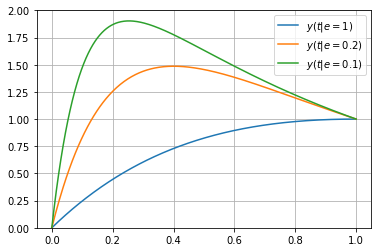

In [20]:
for name,ys in yss_numerical.items():
    plt.plot(xs,ys,label="$y(t|e=%s)$"%name)
plt.legend()
plt.ylim((0,2))
plt.grid()
plt.show()

We find the analytical solution now:

In [21]:
def get_analytical_solution(ee,xs,n=200):
    x = sympy.Symbol("x")
    y = sympy.Function("y")(x)
    y_ = sympy.Derivative(y,x)
    y__ = sympy.Derivative(y_,x)
    sol = sympy.dsolve(
        ee * y__ + (1+ee) * y_ + y, y, ics={y.subs(x,0):0,y.subs(x,1):1})
    sol = sol.rhs
    return [float(sol.subs(x,xx)) for xx in np.linspace(0,1,num=n+1)]

computing for epsilon=1
computing for epsilon=0.2
computing for epsilon=0.1
computing for epsilon=0.01
computing for epsilon=0.001


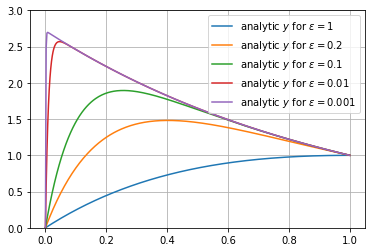

In [22]:
yss_analytical = {}
for e in E:
    if e<1e-6: continue # Smaller values take forever.
    print("computing for epsilon=%s"%e)
    ys = get_analytical_solution(e,xs,n=STEPS)
    yss_analytical[str(e)] = ys
    plt.plot(xs,ys,label="analytic $y$ for $\epsilon=%s$"%e)
plt.legend()
plt.ylim((0,3))
plt.grid()
plt.show()

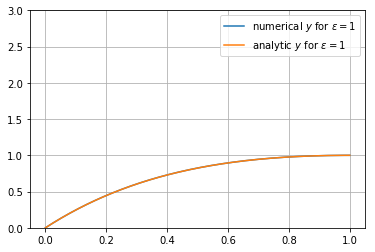

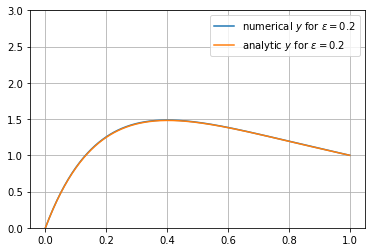

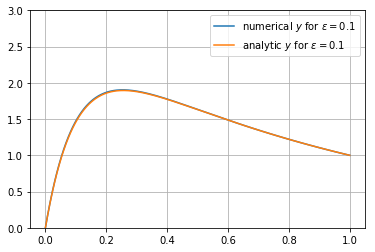

In [23]:
# Plot the analytic solution and the numerical one for the cases when we have both.
for ee_name in yss_numerical:
    if ee_name in yss_analytical:
        plt.plot(xs,yss_numerical[ee_name],label="numerical $y$ for $\epsilon=%s$"%ee_name)
        plt.plot(xs,yss_analytical[ee_name],label="analytic $y$ for $\epsilon=%s$"%ee_name)
        plt.legend()
        plt.ylim((0,3))
        plt.grid()
        plt.show()

The approximation seems almost identical for all $0<x<1$ for the $\epsilon$'s for which the problem could be solved. However, picking *shooting method* and bisection probably was a poor choice, since as $\epsilon$ gets smaller, $y'(0)$ (which must be found) becomes larger ($\epsilon \rightarrow 0 \Rightarrow y'(0) \rightarrow \infty$) very fast, so it's value becomes harder to find.

In [24]:
# Measure the maximum error between the numerical and analytical solutions:
for ee_name in yss_numerical:
    if ee_name in yss_analytical:
        max_error = np.max(np.abs(np.array(yss_numerical[ee_name])-yss_analytical[ee_name]))
        print("max error for epsilon=%5s: %f"%(ee_name,max_error))

max error for epsilon=    1: 0.000549
max error for epsilon=  0.2: 0.006706
max error for epsilon=  0.1: 0.014160


It can be see that the error isn't larger than $0.015$ for the $\epsilon$ for which the problem could be solved with the method used.

<!-- Go for the perturbation approach -->

---

# Item VII

Let $X \in \mathbb{R}^{m \times n}$ with $m \gg n$. Its reduced singular value decomposition is $U \Sigma V^*$ ($X = U \Sigma V^*$). Compute the reduced singular value decomposition of the following matrix $U \Sigma V^* (I - \vec{v}_1 \vec{v}_1^*)$, where $v_1$ is the first column of $V$ and $I$ is the identity matrix. In summary, you need to find $\tilde{U}\tilde{\Sigma}\tilde{V}^*$ such that its product give you $U \Sigma V^* (I - \vec{v}_1 \vec{v}_1^*)$. 

*Hint: This new SVD dependes on the original SVD!*

---

We make
$$
U \Sigma V^* (I - \vec{v}_1 \vec{v}_1^*) = U \Sigma (V^* - V^*\vec{v}_1 \vec{v}_1^*) \,.
$$
Then, we see that
$$
\vec{v}_1 \vec{v}_1^* = \begin{bmatrix}
v_{1,1} \vec{v}_1 \, | \, v_{2,1} \vec{v}_1 | \dots | \, v_{n,1} \vec{v}_1
\end{bmatrix}
$$
and then
$$
V^* \vec{v}_1 \vec{v}_1^* = \begin{bmatrix}
\vec{v}_1^*
\\ \hline \vec{v}_2^*
\\ \hline \vdots
\\ \hline \vec{v}_n^*
\end{bmatrix} \begin{bmatrix}
v_{1,1} \vec{v}_1 \, | \, v_{2,1} \vec{v}_1 | \dots | \, v_{n,1} \vec{v}_1
\end{bmatrix}
$$
Because the $\vec{v}_i$ are orthonormal, this results in:
$$
V^* \vec{v}_1 \vec{v}_1^* = \begin{bmatrix}
v_{1,1} & v_{2,1} & \dots & v_{n,1}
\\ 0 & 0 & \dots & 0
\\ \vdots & \vdots & \ddots & \vdots
\\ 0 & 0 & \dots & 0
\end{bmatrix} = \begin{bmatrix}
\vec{v}_1
\\ \hline \vec{0}
\\ \hline \vdots
\\ \hline \vec{0}
\end{bmatrix}
$$
and
$$
V^* - V^*\vec{v}_1 \vec{v}_1^* =
\begin{bmatrix}
\vec{0}
\\ \hline \vec{v}_2^*
\\ \hline \vdots
\\ \hline \vec{v}_n^*
\end{bmatrix}
$$

---

Let's define the operator $E$ of dimensions $m\times m$ that raises the columns of a matrix 1 position and sends the first one to the last position (let's call that a *circulation*):
$$
E = \begin{bmatrix}
0 & 1 & 0 & \dots & 0 & 0
\\  0 & 0 & 1 & \dots & 0 & 0
\\  \vdots & \vdots & \vdots & \ddots & \vdots & \vdots
\\  0 & 0 & 0 & \dots & 0 & 1
\\  1 & 0 & 0 & \dots & 0 & 0
\end{bmatrix}
$$
We can see that:
$$
E^{-1} = \begin{bmatrix}
 0 & 0 & \dots & 0 & 1
\\ 1 & 0  & \dots & 0 & 0
\\  0 & 1 & \dots & 0 & 0
\\  \vdots & \vdots & \ddots & \vdots & \vdots
\\  0 & 0 & \dots & 1 & 0
\\  0 & 0 & \dots & 0 & 1
\end{bmatrix}
$$
Notice that multiplying by $E^{-1}$ on the right is equivalent to circulate the **columns** of a matrix.

---

If we multiply $(V^* - V^*\vec{v}_1 \vec{v}_1^*)$ by $U \Sigma$ on the left to get our matrix:
$$
U\Sigma(V^* - V^*\vec{v}_1 \vec{v}_1^*) =
U \begin{bmatrix}
\Sigma_1 \vec{0}
\\ \hline \Sigma_2 \vec{v}_2^*
\\ \hline \vdots
\\ \hline \Sigma_n \vec{v}_n^*
\\ \hline \vec{0}
\\ \hline \vdots
\\ \hline \vec{0}
\end{bmatrix} =
U \begin{bmatrix}
0 \cdot \vec{v}_1^*
\\ \hline \Sigma_2 \vec{v}_2^*
\\ \hline \vdots
\\ \hline \Sigma_n \vec{v}_n^*
\\ \hline \vec{0}
\\ \hline \vdots
\\ \hline \vec{0}
\end{bmatrix}
$$
$$
= U E^{-1} E\begin{bmatrix}
0 \cdot \vec{v}_1^*
\\ \hline \Sigma_2 \vec{v}_2^*
\\ \hline \vdots
\\ \hline \Sigma_n \vec{v}_n^*
\\ \hline \vec{0}
\\ \hline \vdots
\\ \hline \vec{0}
\end{bmatrix}
= U E^{-1}
\begin{bmatrix}
\Sigma_2 \vec{v}_2^*
\\ \hline \vdots
\\ \hline \Sigma_n \vec{v}_n^*
\\ \hline \vec{0}
\\ \hline \vdots
\\ \hline \vec{0}
\\ \hline 0 \cdot \vec{v}_1^*
\end{bmatrix}
$$
$$
= U E^{-1} \begin{bmatrix}
\Sigma_2 & 0 & \dots & 0 & 0
\\ 0 & \Sigma_3 & \dots & 0 & 0
\\ \vdots & \vdots & \ddots & \vdots & \vdots
\\ 0 & 0 & \dots & \Sigma_n & 0
\\ 0 & 0 & \dots & 0 & 0
\\ \vdots & \vdots & \ddots & \vdots & \vdots
\\ 0 & 0 & \dots & 0 & 0
\end{bmatrix}
\begin{bmatrix}
\vec{v}_2^*
\\ \hline \vdots
\\ \hline \vec{v}_n^*
\\ \hline \vec{v}_1^*
\end{bmatrix}
$$
$$
= \underbrace{\begin{bmatrix}
\vec{u}_2 | \cdots | \vec{u}_m | \vec{u}_1 
\end{bmatrix}}_{\tilde{U}}
\underbrace{\begin{bmatrix}
\Sigma_2 & 0 & \dots & 0 & 0
\\ 0 & \Sigma_3 & \dots & 0 & 0
\\ \vdots & \vdots & \ddots & \vdots & \vdots
\\ 0 & 0 & \dots & \Sigma_n & 0
\\ 0 & 0 & \dots & 0 & 0
\\ \vdots & \vdots & \ddots & \vdots & \vdots
\\ 0 & 0 & \dots & 0 & 0
\end{bmatrix}}_{\tilde{E}}
\underbrace{\begin{bmatrix}
\vec{v}_2^*
\\ \hline \vdots
\\ \hline \vec{v}_n^*
\\ \hline \vec{v}_1^*
\end{bmatrix}}_{\tilde{V}^*}
$$
Which is equivalent to the SVD of $U\Sigma V(I-\vec{v}_1\vec{v}_1^*)$.

---

# Item VIII

Let $X \in \mathbb{R}^{m \times n}$ with $m \gg n$, prove that maximum of the following maximization problem:
\begin{align}
\max_{w \in \mathbb{R}^n} &\qquad ||X \vec{w} ||^2_2
\\ \text{subject to} &\qquad ||\vec{w}||^2_2 = 1
\end{align}
is obtained for $\vec{w} = \vec{v}_1$, where $\vec{v}_1$ is the first column of $V$ matrix from the singular value decomposition of $X$, i.e. $X = U \Sigma V^*$.

---

We can write
$$
\vec{w} = \sum_{i=1}^n \alpha_i \vec{v}_i
$$

We have that
$$
\begin{align}
X\vec{w} &= U \Sigma V^* \vec{w}
\\ &= U
\begin{bmatrix}
\Sigma_1 \vec{v}_1^*
\\ \hline \Sigma_2 \vec{v}_2^*
\\ \hline \vdots
\\ \hline \Sigma_n \vec{v}_n^*
\\ \hline \vec{0}
\\ \hline \vdots
\\ \hline \vec{0}
\end{bmatrix} \vec{w}
= U
\begin{bmatrix}
\Sigma_1 \alpha_1 \vec{v}_1^*\vec{v}_1
\\ \hline \Sigma_2 \alpha_2 \vec{v}_2^* \vec{v}_2
\\ \hline \vdots
\\ \hline \Sigma_n \alpha_n \vec{v}_n^* \vec{v}_n
\\ \hline \vec{0}
\\ \hline \vdots
\\ \hline \vec{0}
\end{bmatrix}
= U
\begin{bmatrix}
\Sigma_1 \alpha_1
\\ \hline \Sigma_2 \alpha_2
\\ \hline \vdots
\\ \hline \Sigma_n \alpha_n
\\ \hline \vec{0}
\\ \hline \vdots
\\ \hline \vec{0}
\end{bmatrix}
\end{align}
$$
U doens't change the norm 2 of this vector, since it is unitary.
$$
||X \vec{w}||_2^2 = \sum_{i=1}^{n} \Sigma_{i}^2 \alpha_i^2
$$
since there's the restriction that
$$
||\vec{w}||_2^2 = \sum_{i=1}^{n} \alpha_i^2 \quad \leq 1
$$
is clear that the previous expression is maximized when
$$
a_i^2 = \begin{cases}
1 & i=1
\\ 0 & i\neq 1
\end{cases}
$$
as $\Sigma_1^2 \geq \Sigma_i^2 \,\forall i$.

So $\vec{w} = 1 \cdot \vec{v}_1$ maximizes $||X \vec{w}||_2^2$. $\, \square$

---

# Item IX

Repeat the same procedure from the previous questions but for the following maximization problem:
\begin{align}
\max_{w \in \mathbb{R}^n} &\qquad ||X (I - \vec{v}_1 \vec{v}_1^*) \vec{w} ||^2_2
\\ \text{subject to} &\qquad ||\vec{w}||^2_2 = 1
\end{align}

---


We use the SVD for $X (I - \vec{v}_1 \vec{v}_1^*)$ that we found on Item VII:

$$
X (I - \vec{v}_1 \vec{v}_1^*) \vec{w} = \underbrace{\begin{bmatrix}
\vec{u}_2 | \cdots | \vec{u}_m | \vec{u}_1 
\end{bmatrix}}_{\tilde{U}}
\underbrace{\begin{bmatrix}
\Sigma_2 & 0 & \dots & 0 & 0
\\ 0 & \Sigma_3 & \dots & 0 & 0
\\ \vdots & \vdots & \ddots & \vdots & \vdots
\\ 0 & 0 & \dots & \Sigma_n & 0
\\ 0 & 0 & \dots & 0 & 0
\\ \vdots & \vdots & \ddots & \vdots & \vdots
\\ 0 & 0 & \dots & 0 & 0
\end{bmatrix}}_{\tilde{E}}
\underbrace{\begin{bmatrix}
\vec{v}_2^*
\\ \hline \vdots
\\ \hline \vec{v}_n^*
\\ \hline \vec{v}_1^*
\end{bmatrix}}_{\tilde{V}^*} \vec{w}
$$
If we write
$$
\vec{w} = \sum_{i=1}^n \alpha_i \vec{v}_i
$$
again, we have that
$$
\begin{align}
X (I - \vec{v}_1 \vec{v}_1^*) \vec{w} &= \tilde{U} \tilde{\Sigma} \tilde{V}^* \vec{w}
\\ &= \tilde{U}
\begin{bmatrix}
\Sigma_2 \vec{v}_2^*
\\ \hline \Sigma_3 \vec{v}_3^*
\\ \hline \vdots
\\ \hline \Sigma_n \vec{v}_n^*
\\ \hline \vec{0}
\\ \hline \vdots
\\ \hline \vec{0}
\end{bmatrix} \vec{w}
= \tilde{U}
\begin{bmatrix}
\Sigma_2 \alpha_2 \vec{v}_2^* \vec{v}_2
\\ \hline \vdots
\\ \hline \Sigma_n \alpha_n \vec{v}_n^* \vec{v}_n
\\ \hline \vec{0}
\\ \hline \vdots
\\ \hline \vec{0}
\end{bmatrix}
= \tilde{U}
\begin{bmatrix}
\Sigma_2 \alpha_2
\\ \hline \vdots
\\ \hline \Sigma_n \alpha_n
\\ \hline \vec{0}
\\ \hline \vdots
\\ \hline \vec{0}
\end{bmatrix}
\end{align}
$$
The norm of this vector is just
$$
\sum_{i=2}^{n} \Sigma_{i}^2 \alpha_i^2 
$$
as $\tilde{U}$ is unitary.

Again, under the restriction that
$$
||\vec{w}||_2^2 = \sum_{i=1}^{n} \alpha_i^2 \quad \leq 1
$$
we can see that the previous value is maximized when $\alpha_2= 1$ and thus, the other $\alpha_i$ are $0$. Since $\Sigma_{2} \geq \Sigma_{i} \, \forall (i>2)$, and $\Sigma_1$ doesn't add to the norm.

We have So $\vec{w} = 1 \cdot \vec{v}_2$ maximizes the given norm. $\, \square$

---

# Item X

Let
$$
H(x) = \begin{cases}
    1 & \text{if} -0.5 \leq x \leq 0.5
    \\ 0 & \text{otherwise}
\end{cases} \, .
$$

Compute $F(x) = \int_{-\infty}^{\infty} \tilde{H}_a(y) \tilde{H}_b(x-y) \, dx$ where $\tilde{H}_a(x) = \frac{1}{a} H\left( \frac{x}{a} \right)$.

---

We can work with the definition:
\begin{align}
\int_{-\infty}^{\infty} \tilde{H}_a(y) \tilde{H}_b(x-y) \, dx
&= \frac{1}{a} \int_{-\infty}^{\infty} H\left(\frac{y}{a}\right) \tilde{H}_b(x-y) \, dx
\\ &= \frac{1}{a} \int_{-a/2}^{a/2} \tilde{H}_b(x-y) \, dx
\\ &= \frac{1}{ab} \int_{-a/2}^{a/2} H\left(\frac{x-y}{b}\right) \, dx
\\ &= \frac{1}{ab} \int_{-a/2}^{a/2} H\left(\frac{y-x}{b}\right) \, dx
\\ &= \frac{1}{ab} \max\left( R-L, 0 \right)
\end{align}

where
$$
L = \max\left(-\frac{a}{2}, x-\frac{b}{2} \right)
$$
$$
R = \min\left(\frac{a}{2}, x+\frac{b}{2} \right)
$$

In [25]:
def convolution(a,b):
    return lambda x: (a*b)**-1 * max(min(a/2.0,x+b/2.0)-max(-a/2.0,x-b/2.0),0)

In [26]:
conv = convolution(4,3)
conv(-1.5)

0.16666666666666666

---

# Item XI

$%\newcommand{\fou}[2]{\widehat{#1}^{(#2)}}$
$\newcommand{\fou}[2]{\widehat{#1}}$
Use the Fourier transfrom to solve the following PDE:

\begin{align}
u_t - k u_{xx} &= 0 \text{ and } t>0
\\u(x,0) &= f(x) \, , \,  x \in \mathbb{R}
\end{align}
Assume $f$ and $u \in L^{2}(\mathbb{R})$.


---

$$
\newcommand{2}{\fou}{}
$$

We apply the Fourier transform with respect to the variable $x$ on both equations.

In the first one:
\begin{align}
\fou{u_t}{x} - k \fou{u_{xx}}{x} &= 0
\\ \fou{u_t}{x} - k(2\pi i \xi)^2 \fou{u}{x} &= 0
\\ \fou{u_t}{x} + k(2\pi \xi)^2 \fou{u}{x} &= 0 \, .
\end{align}
We now use the following property (see this [link](https://www.math.ubc.ca/~feldman/m267/pdeft.pdf)):
$$
\fou{\frac{\partial u}{\partial t}}{x}(\xi,t) = \frac{\partial \fou{u}{x}(\xi,t)}{\partial t} \,.
$$ and
\begin{align}
\\ \left(\fou{u}{x}\right)_t + k(2\pi \xi)^2 \fou{u}{x} &= 0 
\\ \left(\fou{u}{x}\right)_t &= -k(2\pi \xi)^2 \fou{u}{x} \, .
\end{align}
The solution to this ordinary PDE is:
\begin{align}
\fou{u}{x}(\xi,t) = c(\xi)e^{-k(2\pi \xi)^2 t} 
\end{align}

We can see that at $t=0$:
\begin{align}
\fou{u}{x}(\xi,0) &= c(\xi)
\\ \fou{f}{x}(\xi) &= c(\xi)
\end{align}

Finally, the solution is:
\begin{align}
\fou{u}{x}(\xi,t) &= \fou{f}{x}(\xi)e^{-k(2\pi \xi)^2 t} 
\\ u(x,t) &= \int_{-\infty}^{\infty} \fou{f}{x}(\xi)e^{-k(2\pi \xi)^2 t} e^{2\pi i \xi x} d\xi
\\ &= \int_{-\infty}^{\infty} \fou{f}{x}(\xi)e^{-k(2\pi \xi)^2 t} e^{2\pi i \xi x} d\xi
\end{align}

In [27]:
def discretize(fn,xi,xf,N=101):
    xs = np.linspace(xi,xf,num=N)
    fs = fn(xs)
    return fs

# The discrete fourier transform
def discrete_fourier_transform(fs,derivate=0,inverse=False):
    N = fs.shape[0]
    ns = np.arange(N)
    if inverse:
        ts = [(1.0/N)*np.sum(fs*np.exp(1j*2*np.pi*k/N*ns)) for k in range(N)]
    else:
        ts = [np.sum(fs*np.exp(-1j*2*np.pi*k/N*ns)) for k in range(N)]
    return np.array(ts)

In [28]:
def solve_pde(f,K,xi,xf,tf,N=300,M=50):
    fx = discretize(f,xi,xf,N=N) # u(x,0)
    ees = np.arange(N)/(xf-xi)
    fxt = discrete_fourier_transform(fx)
    ts = np.linspace(0,tf,num=M)
    funct = lambda t: fxt*np.exp(-K*(2*np.pi*ees)**2*t)
    uts = [discrete_fourier_transform(funct(t),inverse=True) for t in ts]
    return uts

In [29]:
X_I = -4
X_F = 4
KK = 0.2
T_F = 10.0

# We test with a function, say:
F_MAX = 1
fn = lambda x: np.exp(-x**2.0)
us = solve_pde(fn,K=KK,xi=X_I,xf=X_F,tf=T_F)
xs = np.linspace(X_I,X_F,num=us[0].shape[0])

def plot_at_time(i=0):
    plt.plot(xs,us[i],'-')
    plt.ylim((0,F_MAX))
    plt.grid()
    plt.title("$u(x,t=%f)$"%(T_F*i/(len(us)-1.0)))
    plt.show()

interact(plot_at_time,i=(0,len(us)-1),continuous_update=False)

interactive(children=(IntSlider(value=0, description='i', max=49), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_at_time(i=0)>

---

# Item XII

Let $\ddot{y}(t)-\mu (1-y^2(t)) \dot{y}(t) + y(t) = 0$, with $y(0)=2$ , $\dot{y}(0)=0$, and $\mu = 1234$.
1. Approximate the solution by means of a Taylor series expansion about $t=0$.
2. Implement a numerical solver for it. *You may not use scipy but you can use numpy*.
3. Compare both solutions and comment on the comparison.
---

## Part 1

We do the approximation:
\begin{align}
y(t) &= y(0) + t \dot{y}(0) + \frac{1}{2} t^2 \ddot{y}(0)
\\ &= 2 + \frac{1}{2}t^2\ddot{y}(0) \,.
\end{align}

In order to compute $\ddot{y}(0)$ we use the equation given, at $t=0$:
\begin{align}
\ddot{y}(0) - \mu(1-y^2(0)) \dot{y}(0) + y(0) &= 0
\\ \ddot{y}(0) &= -y(0)
\\ &= -2 \, .
\end{align}

And the approximation is $$y(t) = 2-t^2 \,.$$

## Part 2

In [30]:
# Euler's method as a higher order function:
def euler(yp=lambda y,t:1,yi=0,tmin=0,tmax=1.0,steps=400):
    delta = (tmax-tmin)/float(steps)
    t = tmin
    ys = []
    ys.append(yi)
    for i in range(steps):
        t = tmin+delta*i
        yp_next = yp(ys[-1],t)
        y_next = ys[-1]+delta*yp_next
        ys.append(y_next)
    return ys

We use it in the following way:

$$
\begin{bmatrix} y_{t+1} \\ \dot{y}_{y+1} \end{bmatrix}
=
\begin{bmatrix} \dot{y}_{t} \\ \ddot{y}(t) \end{bmatrix} \Delta t
+ 
\begin{bmatrix} y_{t} \\ \dot{y}_t \end{bmatrix} \Delta t
$$

remembering that
$$
\ddot{y}(t) = \mu (1-y^2(t)) \dot{y}(t) - y(t) = 0
$$

In [31]:
mu = 1234
N = 40000
YF = 4.0
xs = np.linspace(0,YF,num=N+1)
# --- Approximation with Taylor
y_tay = 2-xs**2.0
# --- Solution:
fn = lambda ys,t: np.array([ys[1], mu*(1-ys[0]**2)*ys[1] - ys[0]])
yini = np.array([2,0])
result = euler(fn,yini,tmin=0,tmax=YF,steps=N)
y_sol = [a[0] for a in result]
yp_sol = [a[1] for a in result]
# --- Print values at some points:
NS = (N//4,N//2,N*3//4,N)
print("Taylor:")
for i in NS:
    print("\ty(%f) = %f"%(xs[i],y_tay[i]))
print("Euler's:")
for i in NS:
    print("\ty(%f) = %f"%(xs[i],y_sol[i]))

Taylor:
	y(1.000000) = 1.000000
	y(2.000000) = -2.000000
	y(3.000000) = -7.000000
	y(4.000000) = -14.000000
Euler's:
	y(1.000000) = 1.999460
	y(2.000000) = 1.998919
	y(3.000000) = 1.998378
	y(4.000000) = 1.997837


## Part 3

Plot both solutions:

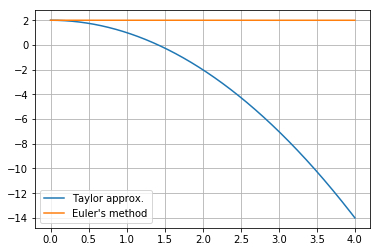

In [32]:
plt.plot(xs,y_tay,label="Taylor approx.")
plt.plot(xs,y_sol,label="Euler's method")
plt.grid()
plt.legend()
plt.show()

It can be seen that the Taylor's approximation is bad as it doens't consider that $y''(t)$ is really small except on $t=0$ (due the large value of $\mu$).

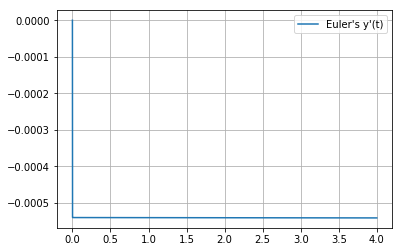

In [33]:
plt.plot(xs,yp_sol,label="Euler's y'(t)")
plt.grid()
plt.legend()
plt.show()

# Item XIII
Let $\gamma$ be a positively oriented circular path with center $0$ at radious $\alpha >2$, compute the following:
* $\int_{\gamma} \frac{\exp(z)}{z} \partial z = 2\pi i$
* $\int_{\gamma} \frac{\exp(z)}{z(z-1)} \partial z = 2\pi i (e-1)$
* $\int_{\gamma} \frac{\exp(z)}{z^3} \partial z = \pi i$

\* **Note**: It seems that the exercises aren't correct.

---

We make use of the definition of the line integral:
$$
\int_{\mathcal {C}}f(\mathbf {r} )\,ds=\int _{a}^{b}f\left(\mathbf {r} (t)\right) \mathbf {r} '(t)\,dt.
$$
In particular, if the curve is a circunference of radious $r$ we can parametrize over the angle $\theta$:
$$
\int_{0}^{2\pi} f\left(\, (r \cos(\theta), r \sin(\theta))\, \right) \, (\cos(\theta)+i \sin(\theta))'r \, \partial \theta
$$
In particular, if the axis $Y$ is for imaginary numbers:
$$
\int_{0}^{2\pi} f\left( r \cos(\theta) + r \sin(\theta) i \right) \, (-\sin(\theta)+ i\cos(\theta))r \, \partial \theta
$$
Using cuadrature:
$$
 \frac{2 \pi}{n} \sum_{i=0}^{n-1} f (r \cos(\theta_i)+ r \sin(\theta_i) i ) \, (-r \sin(\theta_i)+ r i\cos(\theta_i))
$$

In [34]:
# Define the integral approximated as a Riemman sum (not the best way but the easiest).
def circle_integral(fn,rad,imaginary_y=False,vectorized=False,n=300):
    ts = np.linspace(0,2*np.pi,num=n,endpoint=False)
    
    xs = rad*np.cos(ts)
    ys = rad*np.sin(ts)
        
    if imaginary_y:
        if vectorized:
            fs = fn(xs+ys*1j)*(-ys+xs*1j)
        else:
            fs = [fn(x+y*1j)*(-y+x*1j) for x,y in zip(xs,ys)]
    else:
        if vectorized:
            fs = fn(xs,ys)*(-ys+xs*1j)
        else:
            fs = [fn(x,y)*(-y+x*1j) for x,y in zip(xs,ys)]
    
    return (2*np.pi/n)*np.sum(fs)

We compute the intergrals. In order to get the asked results we should consider circular paths where the component Y is imaginary:

In [35]:
functions = [
    ("item1", lambda z: np.exp(z)/z,         lambda a: 2*np.pi*1j),
    ("item2", lambda z: np.exp(z)/(z*(z-1)), lambda a: 2*np.pi*1j*(np.e-1)),
    ("item3", lambda z: np.exp(z)/z**3,      lambda a: np.pi*1j),
]

for name,fun,val in functions:
    print(name+":")
    for alpha in np.arange(2.5,5.01,0.5):
        fun_eval = circle_integral(fun,alpha,imaginary_y=True,vectorized=True)
        fun_eval = round(fun_eval,6)
        val_eval = val(alpha)
        print("\talpha=%4.2f:"%alpha)
        print("\t\tfun_eval:%s"%fun_eval)
        print("\t\tval_eval:%s"%val_eval)

item1:
	alpha=2.50:
		fun_eval:(-0+6.283185j)
		val_eval:6.283185307179586j
	alpha=3.00:
		fun_eval:6.283185j
		val_eval:6.283185307179586j
	alpha=3.50:
		fun_eval:(-0+6.283185j)
		val_eval:6.283185307179586j
	alpha=4.00:
		fun_eval:(-0+6.283185j)
		val_eval:6.283185307179586j
	alpha=4.50:
		fun_eval:(-0+6.283185j)
		val_eval:6.283185307179586j
	alpha=5.00:
		fun_eval:(-0+6.283185j)
		val_eval:6.283185307179586j
item2:
	alpha=2.50:
		fun_eval:(-0+10.796283j)
		val_eval:10.796283138167546j
	alpha=3.00:
		fun_eval:10.796283j
		val_eval:10.796283138167546j
	alpha=3.50:
		fun_eval:10.796283j
		val_eval:10.796283138167546j
	alpha=4.00:
		fun_eval:(-0+10.796283j)
		val_eval:10.796283138167546j
	alpha=4.50:
		fun_eval:(-0+10.796283j)
		val_eval:10.796283138167546j
	alpha=5.00:
		fun_eval:(-0+10.796283j)
		val_eval:10.796283138167546j
item3:
	alpha=2.50:
		fun_eval:3.141593j
		val_eval:3.141592653589793j
	alpha=3.00:
		fun_eval:3.141593j
		val_eval:3.141592653589793j
	alpha=3.50:
		fun_eval:(-

It can be seen that the results aren't the same.

# Item XIV

Show that the following Laurent expansion is valid in $1 < |z| < 2$:
$$
\frac{-1}{(z-1)(z-2)} = \sum_{n=0}^\infty \frac{z^n}{2^{n+1}} + \sum_{n=1}^\infty \frac{1}{z^n} \,,
$$
and draw an sketch of the region. Does it exist an expansion when $|z|>2$? If so, please compute it.

\* **Note**: I had to change the $1$ with $-1$, for the exercise to be correct.

---

We have that:
\begin{align*}
\sum_{n=0}^{\infty} \frac{z^n}{2^{n+1}} &= \frac{1}{2} \sum_{n=0}^{\infty} \frac{z^n}{2^n}
\\ &= \frac{1}{2} \sum_{n=0}^{\infty} \left( z/2 \right)^n
\\ &= \frac{1}{2} \frac{1}{1-z/2} \quad \text{as long as $|z/2|<1$.}
\\ &= \frac{1}{2-z}
\end{align*}
And for the other sum:
\begin{align*}
\sum_{n=1}^{\infty} \frac{1}{z^n}
&= -1 + \sum_{n=0}^{\infty} \frac{1}{z^n}
\\ &= -1 + \sum_{n=0}^{\infty} (1/z)^n
\\ &= -1 + \frac{1}{1-(1/z)} \quad \text{as long as $(|1/z|<1) \Leftrightarrow (z<-1) \vee (z>1)$.}
\\ &= \frac{1}{z-1}
\end{align*}
Adding both results:
\begin{align}
\frac{1}{2-z} + \frac{1}{z-1} &= \frac{-1}{(z-1)(z-2)}
\end{align}

In [36]:
# Function to plot a function
def plot_fun(fn,xi,xf,vectorized=False,n=101,**args):
    xs = np.linspace(xi,xf,num=n)
    if vectorized:
        ys = fn(xs)
    else:
        ys = [fn(x) for x in xs]
    plt.plot(xs,ys,'-',**args)

In [37]:
# The sums, limiting n:
def sums(z,n_max):
    ns = np.arange(n_max+1)
    sum1 = np.sum(z**ns/2**(ns+1))
    sum2 = np.sum(1/z**ns[1:])
    return sum1+sum2

/home/fcasas/Music/p36cpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


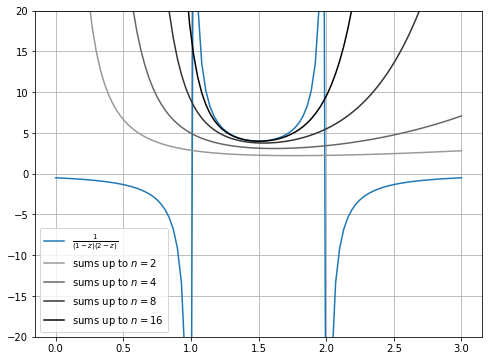

In [38]:
# We plot the region
plt.figure(figsize=(8,6))
plot_fun(lambda x: -1/((x-1)*(x-2)),0,3,vectorized=True,label="$\\frac{1}{(1-z)(2-z)}$")
plot_fun(lambda x: sums(x,2),0,3,label="sums up to $n=2$",c=(.6,.6,.6))
plot_fun(lambda x: sums(x,4),0,3,label="sums up to $n=4$",c=(.4,.4,.4))
plot_fun(lambda x: sums(x,8),0,3,label="sums up to $n=8$",c=(.2,.2,.2))
plot_fun(lambda x: sums(x,16),0,3,label="sums up to $n=16$",c=(.0,.0,.0))
plt.ylim((-20,20))
plt.legend()
plt.grid()
plt.show()

We can see that it converges in $1<|z|<2$ as $n \rightarrow \infty$.

---

We can get the Laurent expansion of the series when $|z|>2$, if we make use of:
$$
\frac{1}{1-z} = \sum_{n=1}^\infty \frac{1}{z^n} \quad \text{if $|z|>1$} \,.
$$
We proceed:
\begin{align*}
\frac{1}{(z-1)(z-2)} &= \frac{1}{2-z} + \frac{1}{z-1}
\\ &= \frac{1}{2} \cdot \frac{1}{1-\frac{z}{2}} - 1 \cdot \frac{1}{1-z}
\\ &= \frac{-1}{2} \sum_{n=1}^\infty \frac{1}{(z/2)^n} + 1 \sum_{n=1}^\infty \frac{1}{z^n}
\\ &= \frac{-1}{2} \sum_{n=1}^\infty \frac{2^n}{z^n} + 1 \sum_{n=1}^\infty \frac{1}{z^n}
\end{align*}


In [39]:
# The new sums, limiting n:
def sums2(z,n_max):
    ns = np.arange(n_max+1)
    sum1 = -0.5*np.sum(2**ns[1:]/z**ns[1:])
    sum2 = np.sum(1/z**ns[1:])
    return sum1+sum2

/home/fcasas/Music/p36cpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/fcasas/Music/p36cpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/fcasas/Music/p36cpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


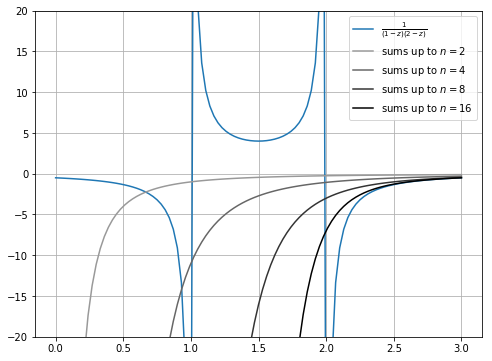

In [40]:
# We plot the region, again
plt.figure(figsize=(8,6))
plot_fun(lambda x: -1/((x-1)*(x-2)),0,3,vectorized=True,label="$\\frac{1}{(1-z)(2-z)}$")
plot_fun(lambda x: sums2(x,2),0,3,label="sums up to $n=2$",c=(.6,.6,.6))
plot_fun(lambda x: sums2(x,4),0,3,label="sums up to $n=4$",c=(.4,.4,.4))
plot_fun(lambda x: sums2(x,8),0,3,label="sums up to $n=8$",c=(.2,.2,.2))
plot_fun(lambda x: sums2(x,16),0,3,label="sums up to $n=16$",c=(.0,.0,.0))
plt.ylim((-20,20))
plt.legend()
plt.grid()
plt.show()

We can see that it converges to the function when $|z|>2$ as $n \rightarrow \infty$.

## References
* http://sym.lboro.ac.uk/resources/Handout-Laurent.pdf

---

# Item XV

Considering the following inner product:
$$
\langle p(x),q(x) \rangle =\int_{-1}^{1} \overline{p(x)}q(x) dx
$$

* Let $A= [1|x|x^2|...|x^{n-1}]$ be the "matrix" whose "columns" are the monomials $x^j$, for $j=0,...,n-1$. Each column is a function in $L^2[-1,1]$. compute the $QR$ decomposition of $A$.
* Let $A=[1|\sin(2\pi x)|\sin(4\pi x)|...|x^{n-1}]$ be the "matrix" whose "columns" are the functions $1$ and $\sin(2\pi x)$, for $j=1,...,n-1$. Each column is a function in $L^2[-1,1]$. Compute the $QR$ decomposition of $A$. 
* Do part (a) numerically. Make sure you understand what you are doing since this is a important concept that links symbolic computing with numerical computing.

---

In [41]:
# This is a generic version of Gram-Schmidt, by default it works on matrices.
# For other uses, replace default argument functions.
def generic_gs(
        elems,
        scalar = lambda a,x : a*x,
        prod = lambda x,y : np.sum(x*y),
        neg = lambda x,y : x-y,
    ):
    """
    elems = [T]
    scalar :: T -> Float -> T
    prod :: T -> T -> Float
    neg :: T -> T -> T
    NOTE: if is used for a regular matrix, elems must be row-wise.
    """
    n = len(elems)
    r = np.zeros((n,n))
    for i in range(n):
        for j in range(i):
            projection = prod(elems[j],elems[i])/prod(elems[j],elems[j])
            r[j,i] = projection
            elems[i] = neg(elems[i],scalar(projection,elems[j]))
        norm2 = prod(elems[i],elems[i])
        if norm2<0:
            print("Warning: negative norm2=%f at i=%d!"%(norm2,i))
            return None
        norm = norm2**0.5
        r[i,i] = norm
        elems[i] = scalar(norm**-1,elems[i])
    return r

In [42]:
def symbolic_inner_product(f,q):
    x = sympy.Symbol('x')
    v = sympy.integrate(f*q,(x,-1,1))
    # We evaluate the expresion as a number because we can't afford the whole symbolic
    # expression...
    return float(v)

In [43]:
# We define the list of functions for part a
def part_a_funcs(n):
    x = sympy.Symbol('x')
    part = [x**i for i in range(n)]
    return part

In [44]:
def part_b_funcs(n):
    x = sympy.Symbol('x')
    part = [x**0] + [sympy.sin(2*i*sympy.pi*x) for i in range(1,n)]
    return part

In [45]:
# We can print an array of functions:
print(part_a_funcs(10))
print(part_b_funcs(10))

[1, x, x**2, x**3, x**4, x**5, x**6, x**7, x**8, x**9]
[1, sin(2*pi*x), sin(4*pi*x), sin(6*pi*x), sin(8*pi*x), sin(10*pi*x), sin(12*pi*x), sin(14*pi*x), sin(16*pi*x), sin(18*pi*x)]


In [46]:
# We compute the decompositions
FUNCS = [part_a_funcs(5),part_b_funcs(5),
         part_a_funcs(20),part_b_funcs(20),
         part_a_funcs(100),part_b_funcs(100)]
for funcs in FUNCS:
    # Print Original matrix
    print("-"*20+"Functions:")
    print(funcs)
    # Perform QR decomposition using generic G-S
    r = generic_gs(funcs,prod=symbolic_inner_product)
    if r is None:
        print("Couldn't compute R!!!:")
    else:
        # Print Q
        print("Q:")
        print(funcs)
        # Print R
        print("R:")
        print(r)

--------------------Functions:
[1, x, x**2, x**3, x**4]
Q:
[0.707106781186547, 1.22474487139159*x, 2.37170824512628*x**2 - 0.790569415042095, 4.67707173346743*x**3 - 2.80624304008046*x, 9.28077650307342*x**4 - 7.95495128834865*x**2 + 0.795495128834865]
R:
[[1.41421356 0.         0.47140452 0.         0.28284271]
 [0.         0.81649658 0.         0.48989795 0.        ]
 [0.         0.         0.42163702 0.         0.36140316]
 [0.         0.         0.         0.21380899 0.        ]
 [0.         0.         0.         0.         0.1077496 ]]
--------------------Functions:
[1, sin(2*pi*x), sin(4*pi*x), sin(6*pi*x), sin(8*pi*x)]
Q:
[0.707106781186547, 1.0*sin(2*pi*x), 1.0*sin(4*pi*x), 1.0*sin(6*pi*x), 1.0*sin(8*pi*x)]
R:
[[1.41421356 0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.   

Q:
[0.707106781186547, 1.0*sin(2*pi*x), 1.0*sin(4*pi*x), 1.0*sin(6*pi*x), 1.0*sin(8*pi*x), 1.0*sin(10*pi*x), 1.0*sin(12*pi*x), 1.0*sin(14*pi*x), 1.0*sin(16*pi*x), 1.0*sin(18*pi*x), 1.0*sin(20*pi*x), 1.0*sin(22*pi*x), 1.0*sin(24*pi*x), 1.0*sin(26*pi*x), 1.0*sin(28*pi*x), 1.0*sin(30*pi*x), 1.0*sin(32*pi*x), 1.0*sin(34*pi*x), 1.0*sin(36*pi*x), 1.0*sin(38*pi*x)]
R:
[[1.41421356 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.      

We can see that the functions of the second item are ortogonal, so the $QR$ decomposition gives the indentity (besides the first function $y(x)=1$ that has to be normalized).

Around $i=25$ the function coeficients become too small to handle. The norm (inner product with itself) of the functions after substracting the projections becomes small, and negative.

In [47]:
FUNCS = [part_a_funcs(100),part_b_funcs(100)]
for funcs in FUNCS:
    # Print Original matrix
    print("-"*20+"Functions:")
    print(funcs)
    # Perform QR decomposition using generic G-S
    r = generic_gs(funcs,prod=symbolic_inner_product)
    if r is None:
        print("Couldn't compute R!!!:")
    else:
        # Print Q
        print("Q:")
        print(funcs)
        # Print R
        print("R:")
        print(r)

--------------------Functions:
[1, x, x**2, x**3, x**4, x**5, x**6, x**7, x**8, x**9, x**10, x**11, x**12, x**13, x**14, x**15, x**16, x**17, x**18, x**19, x**20, x**21, x**22, x**23, x**24, x**25, x**26, x**27, x**28, x**29, x**30, x**31, x**32, x**33, x**34, x**35, x**36, x**37, x**38, x**39, x**40, x**41, x**42, x**43, x**44, x**45, x**46, x**47, x**48, x**49, x**50, x**51, x**52, x**53, x**54, x**55, x**56, x**57, x**58, x**59, x**60, x**61, x**62, x**63, x**64, x**65, x**66, x**67, x**68, x**69, x**70, x**71, x**72, x**73, x**74, x**75, x**76, x**77, x**78, x**79, x**80, x**81, x**82, x**83, x**84, x**85, x**86, x**87, x**88, x**89, x**90, x**91, x**92, x**93, x**94, x**95, x**96, x**97, x**98, x**99]
Couldn't compute R!!!:
--------------------Functions:
[1, sin(2*pi*x), sin(4*pi*x), sin(6*pi*x), sin(8*pi*x), sin(10*pi*x), sin(12*pi*x), sin(14*pi*x), sin(16*pi*x), sin(18*pi*x), sin(20*pi*x), sin(22*pi*x), sin(24*pi*x), sin(26*pi*x), sin(28*pi*x), sin(30*pi*x), sin(32*pi*x), sin(34

---
To do it numerically, let's define a polynomial
$$
p(x) = \sum_{i=0}^{n-1} p_i x^i
$$
as the array of the $p_i$'s.

Then the multiplication becomes:
$$
p(x)q(x) =  \sum_{i=0}^{2n-2} \left( \sum_{k=0}^{i} p_k q_{i-k} \right) x^{i} \,,
$$
then the inner product becomes:
\begin{align*}
\int_{-1}^{1} p(x)q(x) \, dx &= \sum_{i=0}^{2n-2} \left( \sum_{k=0}^{i} p_k q_{i-k} \right) \frac{x^{i+1}}{i+1} |_{x=-1}^{1}
\\ &= \sum_{i=0}^{2n-2} [i \, \text{mod} \, 2= 0] \left( \sum_{k=0}^{i} p_k q_{i-k} \right) \frac{2}{i+1}
\end{align*}

In [48]:
@jit(nopython=True)
def poly_mult(a,b):
    assert(len(a)==len(b))
    n = len(a)
    total = 0
    for i in range(0,2*n-1,2):
        term = 0
        for k in range(0,i+1):
            if k>=0 and i-k>=0 and k<n and i-k<n:
                term += a[k]*b[i-k]
        term *= 2.0/(i+1.0)
        total += term
    return total

In [49]:
def poly_print(poly):
    stri = []
    if len(poly)>0 and poly[0] != 0: stri.append("%.3f"%poly[0])
    if len(poly)>1 and poly[1] != 0: stri.append("%.3fx"%poly[1])
    for i in range(2,len(poly)):
        if poly[i]!=0:
            stri.append("%+.3fx%d"%(poly[i],i))
    if len(stri)==0: return "0"
    return " ".join(stri)

def poly_matrix_print(polys,limit=10):
    print("[")
    if len(polys)>2*limit:
        for poly in polys[:limit]:
            print("  "+poly_print(poly)+" |")
        print("  ...")
        for poly in polys[-limit:]:
            print("  "+poly_print(poly)+" |")
    else:
        for poly in polys:
            print("  "+poly_print(poly)+" |")
    print("]")

In [50]:
poly_mult([1,2,3],[2,5,1])

16.53333333333333

In [51]:
for N in (5,10,100):
    # Print Original matrix
    polys = np.eye(N)
    print("-"*20+" Original (N=%d):"%N)
    poly_matrix_print(polys)
    # Perform QR decomposition using generic G-S
    r = generic_gs(polys,prod=poly_mult)
    # Print Q
    print("Q:")
    poly_matrix_print(polys)
    # Assert that Q is orthonormal
    for i in range(N):
        for j in range(N):
            if i==j:
                assert(np.abs(poly_mult(polys[i],polys[j])-1)<1e-5)
            else:
                assert(np.abs(poly_mult(polys[i],polys[j]))<1e-5)
    # Print R
    print("R:")
    print(r)

-------------------- Original (N=5):
[
  1.000 |
  1.000x |
  +1.000x2 |
  +1.000x3 |
  +1.000x4 |
]
Q:
[
  0.707 |
  1.225x |
  -0.791 +2.372x2 |
  -2.806x +4.677x3 |
  0.795 -7.955x2 +9.281x4 |
]
R:
[[1.41421356 0.         0.47140452 0.         0.28284271]
 [0.         0.81649658 0.         0.48989795 0.        ]
 [0.         0.         0.42163702 0.         0.36140316]
 [0.         0.         0.         0.21380899 0.        ]
 [0.         0.         0.         0.         0.1077496 ]]
-------------------- Original (N=10):
[
  1.000 |
  1.000x |
  +1.000x2 |
  +1.000x3 |
  +1.000x4 |
  +1.000x5 |
  +1.000x6 |
  +1.000x7 |
  +1.000x8 |
  +1.000x9 |
]
Q:
[
  0.707 |
  1.225x |
  -0.791 +2.372x2 |
  -2.806x +4.677x3 |
  0.795 -7.955x2 +9.281x4 |
  4.397x -20.521x3 +18.469x5 |
  -0.797 +16.731x2 -50.193x4 +36.809x6 |
  -5.991x +53.916x3 -118.616x5 +73.429x7 |
  0.797 -28.699x2 +157.846x4 -273.599x6 +146.571x8 |
  7.585x -111.248x3 +433.869x5 -619.813x7 +292.689x9 |
]
R:
[[1.41421356 0.   

AssertionError: 

We can see that the numerical method fails for $N=100$. After a closer inspection, this was because, after substracting the projection with the previous functions, the remaining polynomial had very small coefficients, around $i=25$ too.

---

# Item XVI

Let $f(x) = \sum_{i=1}^n \alpha_i \text{sinc}(x-x_i)$ where $\text{sinc}(x) = \frac{\sin(x)}{x}$. Compute the total number of operations needed for evaluation of $f(x)$ at $x_j$, for $j=1 \dots n$. Also implement this algorithm and validate your estimation.

---

The first observation is that $\text{sinc}(x-x_i)$ should be defined as $\text{sinc}(0)=1$ when $x=x_i$. In this case, it's not necessary to compute one of the $\sin$'s nor the division.

So, for evaluating the function on a particular point $x$, the amount of $\sin$ that have to be calculated is $n$, but if $x=x_j$ for some $j$, then $n{-}1$ $\sin$ have to be calculated. The same goes for the amount of divisions by $x-x_j$, substractions to get $x-x_j$, multiplications by $a_j$ and $n-1$ sums to get the final amount.

| Operation | Times performed | Total ops. |
|:------| -----:| ---: |
| compute $x-x_j$  | $n$ | $n$ |
| compute $\sin(x-x_j)$ | $n-1$ | $(n-1)C$ |
| divide $\sin(x-x_j)$ by $x-x_j$ | $n-1$ | $n-1$ |
| multiply by $a_i$ | $n-1$ | $n-1$ |
| sum over $i$ | $n-1$ | $n-1$ |

This results in $4n-3+C(n-1)$ operations for each $f(x_j)$, if we compute add the operations required to compute all of them, we will end with $n(4n-3+C(n-1)) = O(n^2)$ where $C$ is the cost of computing a $\sin$.

Of course, additional optimizations could be done if some relations between the $x_j$ hold.

In [52]:
def sinc_sum(xs,alphas):
    n = len(xs)
    def loc_func(x):
        delta_xs = x-xs
        sinc = np.ones(n)
        sinc[delta_xs!=0] = np.sin(delta_xs[delta_xs!=0])/delta_xs[delta_xs!=0]
        return np.sum(alphas*sinc)
    return loc_func

In [53]:
N = np.logspace(1,4.4,num=30,dtype='int') # from 10 to ~25000
ts = []
for n in N:
    xsi = np.random.random(n)
    asi = np.random.random(n)
    f = sinc_sum(xsi,asi)
    start = time.time()
    f_evals = [f(x) for x in xsi]
    end = time.time()
    ts.append(end-start)
ts = np.array(ts)

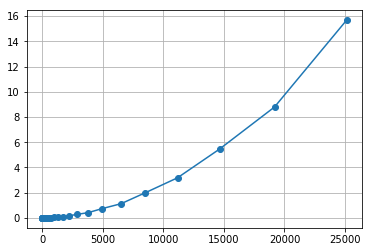

In [54]:
plt.plot(N,ts,'o-')
plt.grid(True)
plt.show()

We perform a linear regression with the last points, in logarithmic scale

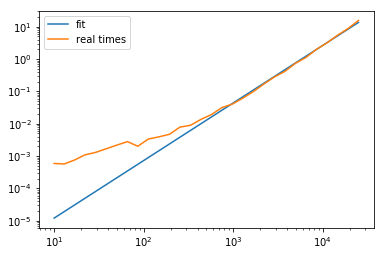

In [55]:
regr = linear_model.LinearRegression()
start = len(N)//2
logN = np.log(N.reshape((-1,1)))
logt = np.log(ts.reshape((-1,1)))
regr.fit(logN[start:],logt[start:])
# Check predictions:
res = np.exp(regr.predict(logN))
plt.loglog(N,res,label="fit")
plt.loglog(N,ts,label="real times")
plt.legend()

In [56]:
print("regr. coef     : %f"%regr.coef_)
print("regr. intercept: %f"%regr.intercept_)

regr. coef     : 1.780168
regr. intercept: -15.423839


We can see that the resulting fit was:

\begin{align}
\log(t) &= 1.794841 \log(n) -15.550982 \\
t &= e^{1.794841 \log(n) -15.550982} \\
t &= 1.76\cdot10^{-7} n^{1.794841} 
\end{align}

Which is somewhat near the $O(n^2)$ expected.

---

# Item XVII

Let $x_i= \langle x_i,y_i \rangle$, for $i=1:n$, a set of points that describe a simple polygon. Derive an algorithm that computes the area enclosed by it exactly.

---

$$
\newcommand{\pa}{\partial}
$$ 
We consider the Green's theorem, that says:

> Let $C$ be a positively oriented, piecewise smooth, simple closed curve in a plane, and let $D$ be the region bounded by $C$. If $L$ and $M$ are functions of $(x, y)$ defined on an open region containing $D$ and have continuous partial derivatives there, then: $$
\oint_C(L \, \pa x  + M \, \pa y) = \iint_D\left(\frac{\pa M}{\pa x}-\frac{\pa L}{\pa y}\right) \pa x \pa y
$$

If we make
$$
\frac{\pa M}{\pa x}-\frac{\pa L}{\pa y} = 1 \,,
$$ e.g. by defining:
$$
M(x,y) = 0 \qquad L(x,y) = -y
$$
this results in:
$$
-\oint_C( y \, \pa x) = \iint_D \pa x \pa y = \text{Area.}
$$

$$
-\oint_C( y(x) \, \pa x) = - \sum_{i=0}^{n-1} \int_{x_{i-1}}^{x_i} y(x) \pa x = 
- \sum_{i=0}^{n-1} \frac{1}{2} (y_{i}+y_{i-1})(x_i-x_{i-1})
$$
where we define $x_{-1}=x_{n-1}$.

So, with the previous formula we can compute the area of the polygon.

In [57]:
def area(ps):
    ps = np.array(ps)
    assert(len(ps.shape)==2)
    assert(ps.shape[1]==2)
    n = ps.shape[0]
    # get the points (add the first ones at the end again).
    xs = ps[:,0]+ps[-1:,0]
    ys = ps[:,1]+ps[-1:,1]
    # for each segment, compute the integral
    areas = (xs[1:]-xs[:-1])*(ys[1:]+ys[:-1])/2.0
    # sum areas, retrieve abs (in case points are in inverse order).
    return np.abs(np.sum(areas))

In [58]:
area([[1,1],[3,1],[5,2],[3,4],[1,3]])

8.0

In [59]:
area([[-3,3],[2,3],[2,-1],[-3,-1]])

20.0

---

# Item XVIII

Let $A_n$:
$$
A_n = 
\begin{bmatrix}
1 & -2 &  0 & \dots & 0 \\
0 &  1 & -2 & 0 & \dots \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
\vdots & \ddots & 0 & 1 & -2 \\
0 & \dots & \dots & 0 & 1
\end{bmatrix} \in \mathbb{R}^{n \times n}
$$
* Determine $A_n^{-1}$
* Determine $\kappa_\infty(A_n) = ||A_n||_\infty ||A_n^{-1}||_\infty$.
* Solve the largest linear system of equations you can solve in 1 minute with the solution $x$ equal to $-1_n + U (-\delta,\delta)$ using Backward Substitution for $\delta =10^{-14}$. Notice, after you generate $x$ you need to find the RHS and then solve it, hopefully, coming back to the solution you defined previously. Did you recover the solution? 
---

### Item A
We can write $A_n = I + R$ where 
$$
R = [r_{ij}]_{i \in \{1..n\}\\j \in \{1..n\}} \text{ where } r_{ij} =
\begin{cases}
-2 & \text{if $j=i+1$} \\
0 &  \text{otherwise}
\end{cases}
$$
We can see that:
$$
R^k = \left[r^{(k)}_{ij}\right]_{i \in \{1..n\} \\ j \in \{1..n\}} \text{ where } r_{ij} =
\begin{cases}
(-2)^k & \text{if $j=i+k$} \\
0 &  \text{otherwise}
\end{cases}
$$

And we make use of the identity [1]:
$$
(I + R)^{-1} = I + \sum_{k=1}^{n-1} (-1)^k R^{k}
$$

And thus we have:
\begin{align}
A_n^{-1} &= \begin{bmatrix}
1 & 2 & 4 & 8 & 16 & \dots & \\
0 & 1 & 2 & 4 & 8 & \dots & \\
\vdots & \ddots & \ddots & \ddots & \ddots \\
0 & \dots & \dots & \dots & \dots & 1 \\
\end{bmatrix}
\\&= [a^{(-1)}_{ij}]_{i \in \{1..n\}\\ j \in \{1..n\}} \text{ where } a^{(-1)}_{ij} =
\begin{cases}
2^{j-i} & \text{if $j \geq i$} \\
0 & \text{otherwise}
\end{cases}
\end{align}

### Item B

The definition of the norm $||A||_\infty$ is:
$$
\sup_x \frac{||Ax||_\infty}{||x||_\infty}
$$
In order to calculate $||A||_\infty$, let $w$ be the vector so that:
$$
\sup_x \frac{||Ax||_\infty}{||x||_\infty} = \frac{||Aw||_\infty}{||w||_\infty} \quad \wedge \quad ||w||_\infty=1
$$
We have that
$$
||Aw||_\infty = \max\left(\max(w_i -2 w_{i+1} )_{i \in \{1..n{-}1\}},w_{n}\right)
$$
this can be maximized when $w_i=1$ and $w_{i+1}=-1$ for any $i<n$.

So, we can pick the vector:
$$
w = [1,-1,0,\dots,0]
$$
that follows the conditions.

And we have that $\frac{||Aw||_\infty}{||w||_\infty} = ||A||_\infty = 3$.


For $||A^{-1}_n||$ we can see that the first component of $Aw$ will have the largest absolute value if each $w_i$ has the same sign (as $||A^{-1}_n w||$ would be smaller if this doesn't hold), so we pick $w = [1,1,1,\dots,1]$, as it maximizes:
$$
||Aw||_\infty = \sum_{k=0}^{n-1} 2^k w_i
$$
while ensuring $||w||_\infty=1$.

This results in
$$
||A^{-1}_n w|| = \sum_{k=0}^{n-1} 2^k w_i = \sum_{k=0}^{n-1} 2^k = 2^n-1 = ||A^{-1}_n|| \,.
$$

Finally $\kappa_\infty(A_n) = ||A_n||_\infty ||A_n^{-1}||_\infty = 3 \cdot (2^{n}-1)$

### Item C

Assuming a general implementation of backward sustitution is requested (it will be more efficient to just work with the cells on the extended diagonal).

In [60]:
def problem(n,theta=1e-14):
    sol = -1.0+(2*np.random.random(n)-1.0)*theta
    matrix_a = scipy.sparse.eye(n,dtype='int',format="lil")
    j_s = range(1,n)
    i_s = range(0,n-1)
    matrix_a[(i_s,j_s)] = -2
    return matrix_a,sol

In [61]:
def backward_subs(matrix,b):
    n = matrix.shape[0]
    xs = np.zeros(n)
    for i in range(n-1,-1,-1):
        col = matrix[i,i+1:].toarray()
        xs[i] = b[i] - np.sum(xs[i+1:]*col)
        xs[i] /= matrix[i,i]
    return xs

In [62]:
aa,bb = problem(10)
print(aa)
print(np.array(aa[2,3:]))
print(bb)

  (0, 0)	1
  (0, 1)	-2
  (1, 1)	1
  (1, 2)	-2
  (2, 2)	1
  (2, 3)	-2
  (3, 3)	1
  (3, 4)	-2
  (4, 4)	1
  (4, 5)	-2
  (5, 5)	1
  (5, 6)	-2
  (6, 6)	1
  (6, 7)	-2
  (7, 7)	1
  (7, 8)	-2
  (8, 8)	1
  (8, 9)	-2
  (9, 9)	1
  (0, 0)	-2
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [63]:
xx = backward_subs(aa,bb)
recovered_bb = aa.dot(xx)
print("bb")
print(bb)
print("recovered_bb")
print(recovered_bb)

bb
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
recovered_bb
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


We generate problems up to $n=100$. Larger problems weren't generated because the powers of 2 do overflow (altough we could make problems of a size large enough to that the Backpropagation takes 1min, some of the values on it will be $\text{nan}$.

In [64]:
# Now generate larger problem
SIZES = [10,100,1000]
AAs = {}
BBs = {}
XXs = {}

for siz in SIZES:
    print("Backward substitution on size %d:"%siz)
    aa,bb = problem(siz)
    AAs[siz] = aa
    BBs[siz] = bb
    %time xx = backward_subs(aa,bb)
    XXs[siz] = xx

Backward substitution on size 10:
CPU times: user 2.84 ms, sys: 3 µs, total: 2.84 ms
Wall time: 3 ms
Backward substitution on size 100:
CPU times: user 15.7 ms, sys: 1e+03 ns, total: 15.7 ms
Wall time: 16.1 ms
Backward substitution on size 1000:
CPU times: user 87.2 ms, sys: 0 ns, total: 87.2 ms
Wall time: 87.5 ms


In [65]:
for siz in SIZES:
    aa = AAs[siz]
    bb = BBs[siz]
    xx = XXs[siz]
    recovered_bb = aa.dot(xx)
    print("For n=%d"%siz)
    print("    bb")
    print(recovered_bb)
    print("    Max error: %f"%(np.max(np.abs(recovered_bb-bb))))

For n=10
    bb
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
    Max error: 0.000000
For n=100
    bb
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
    Max error: 1.000000
For n=1000
    bb
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  

We can se that the recovered $b$ only has value $-1$ in the last components, and the previous ones cannot be reconstructed. It can also be seen that $10^{-14}$ is a variation too small and it's absorved by the $-1$.

### References

* [1] https://math.stackexchange.com/a/47554

---

# Item XIX

Implement the Conjugate Gradient Method with symmetric preconditioner. Select a convenient problem of your choice, but not a trivial one and test it. Please describe the problem and implementation completely.

---

In [66]:
# This is a regular version of the Conjugate Gradient, but generalized
# so the preconditioner can be added as a function that multiplies a vector
# (by default this function keeps it as it is)
def conjugate_gradient(A,b,pinv=lambda x:x,x0=None,threshold=1e-12):
    n = A.shape[0]
    if x0 is None: x0 = np.zeros(n)
    #
    r0 = b - np.dot(A,x0) # Initial residual.
    z0 = pinv(r0) # Initial residual after using the preconditioner.
    p0 = z0 # First conjugate vector (P^-1 A) (basis)
    #
    xk = x0
    rk = r0
    pk = p0
    zk = z0
    #
    for k in range(n):
        ak = np.dot(rk,zk)/np.dot(pk,np.dot(A,pk))
        # ^ coefficient for pk on x that minimizes next residual
        xk1 = xk + ak*pk
        # ^ Update x, add the projection on the direction of the new conjugate vector
        rk1 = rk - ak*np.dot(A,pk)
        # ^ Update residual
        zk1 = pinv(rk1)
        # ^ Residual after using preconditioner
        divi = np.dot(zk,rk)
        if np.abs(divi)<threshold: break # Terminate if residual is too small
        bk = np.dot(zk1,rk1)/divi
        pk1 = zk1 + bk*pk
        # ^ Next conjugate vector
        #
        # Move forward
        xk = xk1
        rk = rk1
        pk = pk1
        zk = zk1
    return xk1

In [67]:
def random_positive_definite_diag_dominant_matrix(n):
    # We create a simetric matrix multiplying a matrix by itself
    # the values decrease fast while descending with the diagonal
    # (the idea is to make it ill-conditioned)
    a = np.random.random((n,n)) * (np.arange(1.0,n+1)**-4)
    A = np.dot(a,a.T)
    # We change the diagonal to make it diagonal dominant
    sumr = np.sum(A,axis=0)
    np.fill_diagonal(A,sumr)
    return A
# Just test code.
N = 5
A = random_positive_definite_diag_dominant_matrix(N)
b = np.random.random(N)
print(A)
print(b)
x1 = np.linalg.solve(A,b)
x2 = conjugate_gradient(A,b)
print(x1)
print(x2)

[[0.2669838  0.09626508 0.05978532 0.07277439 0.01569995]
 [0.09626508 1.19029861 0.26541093 0.32946406 0.06460462]
 [0.05978532 0.26541093 0.72987629 0.20103621 0.04066916]
 [0.07277439 0.32946406 0.20103621 0.90183614 0.04872719]
 [0.01569995 0.06460462 0.04066916 0.04872719 0.18101095]]
[0.18634435 0.99538358 0.60617488 0.57918701 0.09113286]
[0.28210164 0.62117323 0.50132725 0.27699336 0.07009275]
[0.28210164 0.62117323 0.50132725 0.27699336 0.07009275]


Let's consider the Jacobi preconditioner (the preconditioner is the diagonal of the matrix, so the inverse is simple), that is good for diagonal dominant matrices and also is simmetrical.

In [68]:
def jacobi_preconditioner_inv(A):
    P = np.diag(A)**-1
    return lambda x: P*x

In [69]:
NS = (10,100,1000,2000)

for nn in NS:
    AA = random_positive_definite_diag_dominant_matrix(nn)
    bb = np.random.random(nn)
    xx = conjugate_gradient(AA,bb)
    xx2 = conjugate_gradient(AA,bb,pinv=jacobi_preconditioner_inv(AA))
    # Check error:
    print("For n=%d:"%nn)
    err = np.mean(np.abs(np.dot(AA,xx)-bb))
    print("\tregular error: "+str(err))
    err2 = np.mean(np.abs(np.dot(AA,xx2)-bb))
    print("\tprecond error: "+str(err2))

For n=10:
	regular error: 3.787732627547058e-12
	precond error: 1.1547155925883957e-09
For n=100:
	regular error: 4.955984410567882e-08
	precond error: 3.457024370934203e-10
For n=1000:
	regular error: 1.53790994993977e-08
	precond error: 4.449742692369529e-13
For n=2000:
	regular error: 1.4590762507217177e-08
	precond error: 9.075221520452037e-14


We can see that it allows us to decrease the error when $n$ gets larger.